# Linear Dynamic Harmonic Regression (LDHR)

__Parece que los notebooks no están muy perfecionados (o mi instalación tiene problemas). Algunos comandos fallan la primera vez que se ejecutan.__

Para el filtrado (filtro de Kalman y suavizado de intervalo fijo) usaremos la toolbok [E4](https://www.ucm.es/e-4/), para ello es necesario ejecutar lo siguiente:

In [27]:
#clear all
#format

In [28]:
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


Tambien es necesario cargar el toolbox de control

In [29]:
pkg load control

Creo un diccionario (struct) de diccionarios con los nombres códigos y etiquetas de los cuatro indicadores del Indicador Adelantado

In [30]:
s = struct ("nombre",   {"casas",   "cemento", "turismos", "vcarga"},
            "codigo",   {"230410g", "236000" , "271200"  , "282100"},
            "etiqueta", {"NUMERO VIVIENDAS OBRA NUEVA","CONSUMO APARENTE DE CEMENTO","MATRICULACIONES DE TURISMOS","MATRICULACION DE VEHICULOS DE CARGA"});

Cargo las series en memoria 
* la primera columna tiene fechas y la segunda los datos originales 
* el nombre que asigna octave añade una "X" delante del código de cada variable).

Guardo los datos en logaritmos de cada serie 
* cada una con su "nombre"

Las pinto 
* incluyendo la correspondiente "etiqueta"

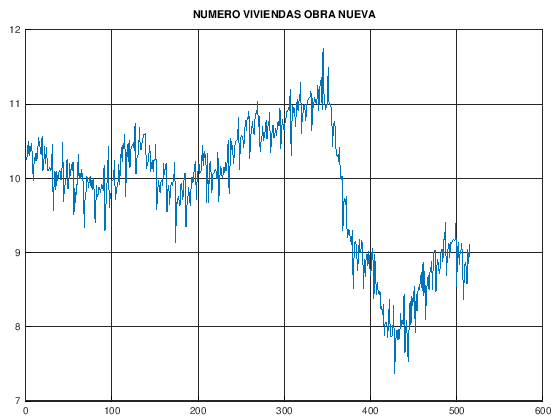

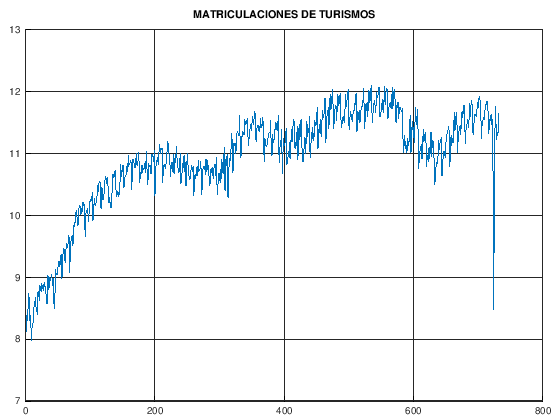

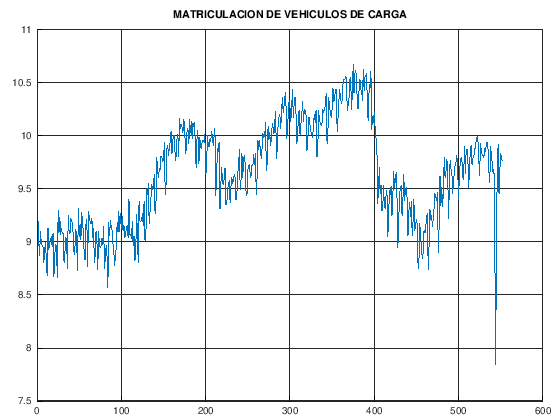

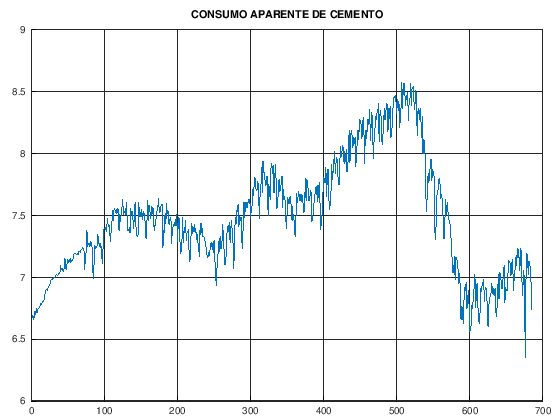

In [31]:
%plot --format png
for i = 1:size(s,2)
    eval(sprintf("load %s",strcat("data/dataFECHAS/", s(i).("codigo"), ".dat")))
    eval(sprintf("%s=log(%s(:,2));", s(i).("nombre"), strcat("X",s(i).("codigo"))))
    figure(i)
    grid on
    hold on
    title(s(i).("etiqueta"))
    eval(sprintf("plot(%s)",s(i).("nombre")))
end

Primera y última fecha común

In [32]:
inicio=[];
final=[];
for i = 1:size(s,2)
    inicio(i)=eval(strcat("X",s(i).("codigo"),"(1,1)"));
    final (i)=eval(strcat("X",s(i).("codigo"),"(end,1)"));
end
inicio=max(inicio)
final =min(final)

inicio = 197801
final = 202011


Truncamos las series para tener una muestra con fechas comunes

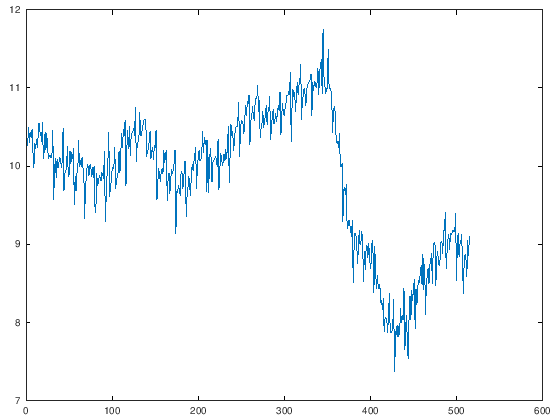

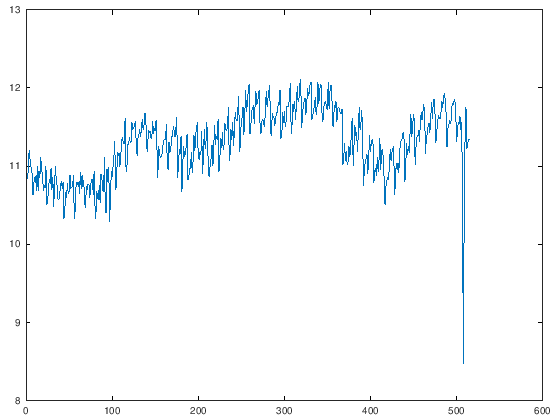

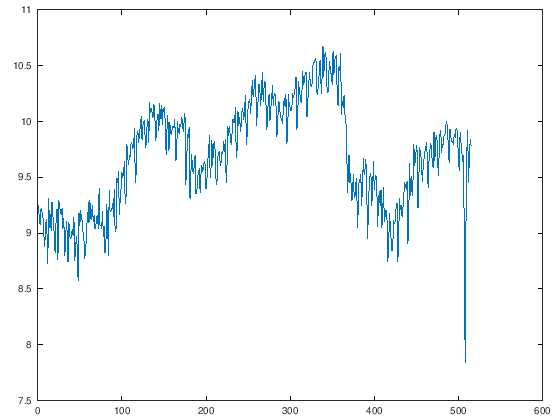

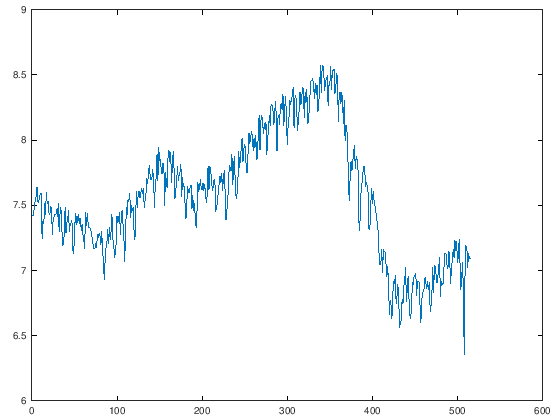

In [33]:
for i = 1:size(s,2)
    ini=find(eval(strcat("X",s(i).("codigo"),"(:,1)"))==inicio);
    fin=find(eval(strcat("X",s(i).("codigo"),"(:,1)"))==final);
    eval(sprintf("%s=%s(ini:fin);", s(i).("nombre"), s(i).("nombre")))
    figure(i)
    eval(sprintf("plot(%s)", s(i).("nombre")))
end

En `PaP` guadaremos un vector con los periodos correspondientes a la estacionalidad para datos mensuales:

In [34]:
PaP=12./(0:6)

PaP =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000



En `TVPaP` guardamos el modelo por defecto IRW para la tendencia y RW los componentes DHR estacionales

In [35]:
TVPaP=[1 1 1 1 1 1 1;1 0 0 0 0 0 0]

TVPaP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0



## El análisis de cada serie lo haremos por separado
### Casas
Vamos a forzar el modelo por defecto

In [36]:
[VAR,P,TVP,oar]=autodhr(casas,12,[],[],PaP,TVPaP,1) 

VAR =

 Columns 1 through 6:

   1.3460e-02   5.2198e-05   5.8139e-05   9.4018e-05   1.1044e-04   7.9563e-05

 Columns 7 and 8:

   2.1919e-05   1.1731e-05

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 34


Podemos calcular los ratios de varianzas (NVR) del siguiente modo:

In [37]:
NVR=VAR(2:8)./VAR(1)

NVR =

 Columns 1 through 6:

   3.8779e-03   4.3193e-03   6.9848e-03   8.2052e-03   5.9110e-03   1.6284e-03

 Column 7:

   8.7155e-04



Vamos a filtrar los componentes con el modelo identificado

In [38]:
filt=0;
[casasTrend,season,cycle,irreg]=dhrfilt(casas,P,TVP,VAR,12,filt,0);

Visualicemos los componentes

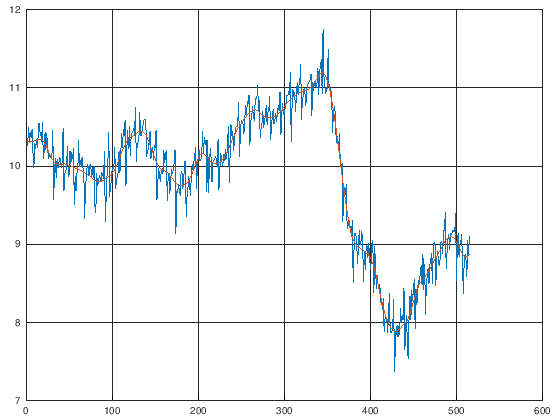

In [39]:
grid on
hold on
plot([casas,casasTrend(:,1)])

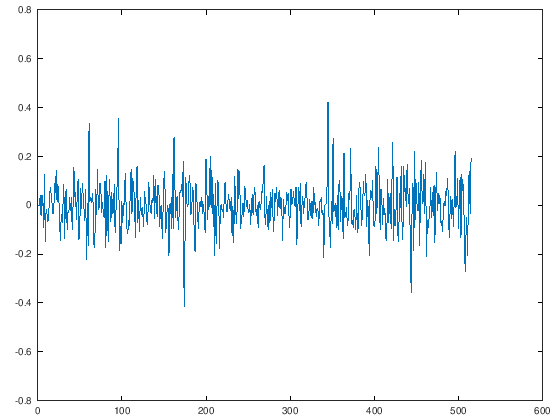

In [40]:
plot([irreg])

### Cemento

In [41]:
[VAR,P,TVP,oar]=autodhr(cemento,12,[],[],PaP,TVPaP,1) 
NVR=VAR(2:8)./VAR(1)
[cementoTrend,season,cycle,irreg]=dhrfilt(cemento,P,TVP,VAR,12,filt,0);

VAR =

 Columns 1 through 6:

   1.9101e-03   7.9672e-06   3.1573e-05   1.8435e-05   1.9972e-05   3.5134e-05

 Columns 7 and 8:

   2.3634e-05   9.1527e-07

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 33
NVR =

 Columns 1 through 6:

   4.1711e-03   1.6530e-02   9.6515e-03   1.0456e-02   1.8394e-02   1.2373e-02

 Column 7:

   4.7917e-04



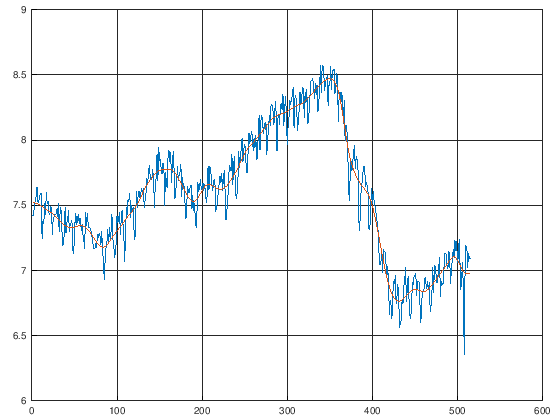

In [42]:
grid on
hold on
plot([cemento,cementoTrend(:,1)])

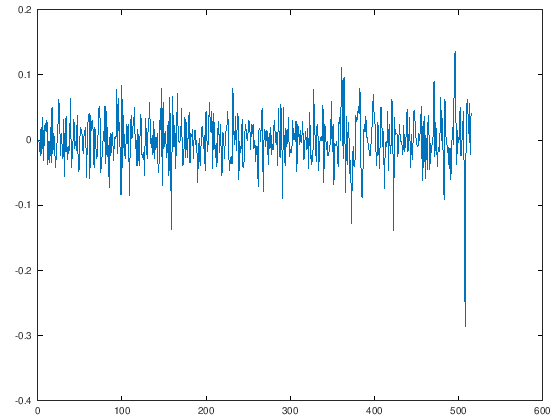

In [43]:
plot(irreg)

### Turismos

In [44]:
[VAR,P,TVP,oar]=autodhr(turismos,12,[],[24:45],PaP,TVPaP,1) 
NVR=VAR(2:8)./VAR(1)
[turismosTrend,season,cycle,irreg]=dhrfilt(turismos,P,TVP,VAR,12,filt,0);

VAR =

 Columns 1 through 6:

   6.3301e-03   1.2003e-05   4.1595e-04   2.0214e-04   1.6057e-04   9.4122e-05

 Columns 7 and 8:

   6.2968e-05   2.8748e-05

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 32
NVR =

 Columns 1 through 6:

   1.8962e-03   6.5710e-02   3.1932e-02   2.5366e-02   1.4869e-02   9.9473e-03

 Column 7:

   4.5415e-03



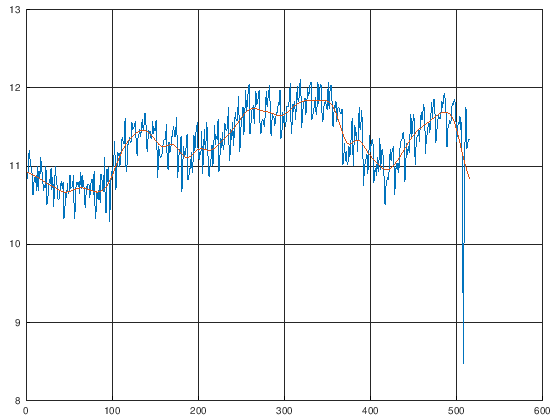

In [45]:
grid on
hold on
plot([turismos,turismosTrend(:,1)])

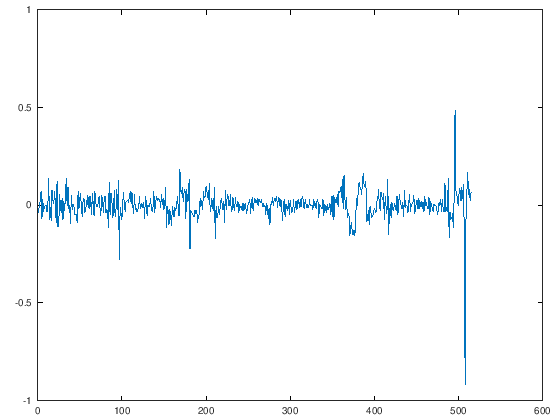

In [46]:
plot(irreg)

### Vehículos de carga

In [47]:
[VAR,P,TVP,oar]=autodhr(vcarga,12,[],[24:45],PaP,TVPaP,1) 
NVR=VAR(2:8)./VAR(1)
[vcargaTrend,season,cycle,irreg]=dhrfilt(vcarga,P,TVP,VAR,12,filt,0);

VAR =

 Columns 1 through 6:

   5.1928e-03   1.8321e-05   1.3329e-04   1.0972e-04   6.4973e-05   4.4531e-05

 Columns 7 and 8:

   1.7305e-05   5.7625e-06

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 37
NVR =

 Columns 1 through 6:

   3.5281e-03   2.5667e-02   2.1128e-02   1.2512e-02   8.5756e-03   3.3324e-03

 Column 7:

   1.1097e-03



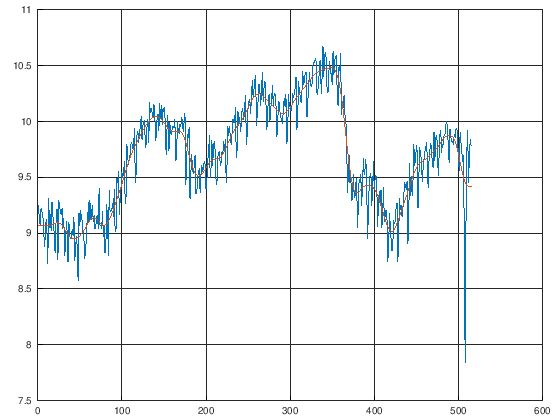

In [48]:
grid on
hold on
plot([vcarga,vcargaTrend(:,1)])

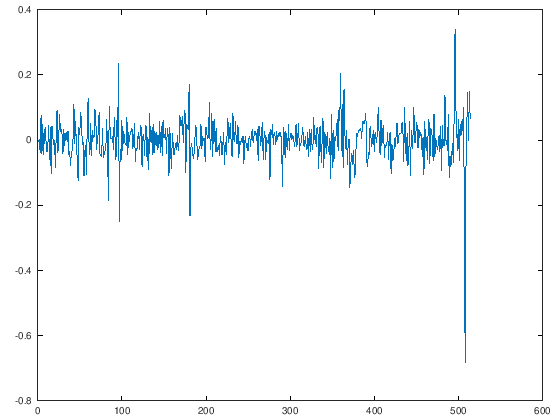

In [49]:
plot(irreg)

In [50]:
k = 5;
b = [casasTrend(:,1),cementoTrend(:,1),turismosTrend(:,1),vcargaTrend(:,1)]';
#b = b(:,1:300);
B = b*(eye(length(b))-ones(length (b))/length(b));
[V, LAMBDA] = eig( B(:,1:length(b)-k)*B(:,k+1:length(b))'/(length(b)^(1)) )

V =

   0.827653   0.448779   0.336075  -0.129091
   0.413894  -0.118396  -0.882464   0.069818
   0.190116  -0.633494   0.149914  -0.735355
   0.327930  -0.619084   0.292979   0.661599

LAMBDA =

Diagonal Matrix

   9.8679e-01            0            0            0
            0   2.1123e-01            0            0
            0            0   3.4581e-02            0
            0            0            0   5.2340e-03



In [51]:
[m,ix]  = max(diag(LAMBDA ));
Weights = V(:,ix)./sum(V(:,ix))

Weights =

   0.4704
   0.2352
   0.1080
   0.1864



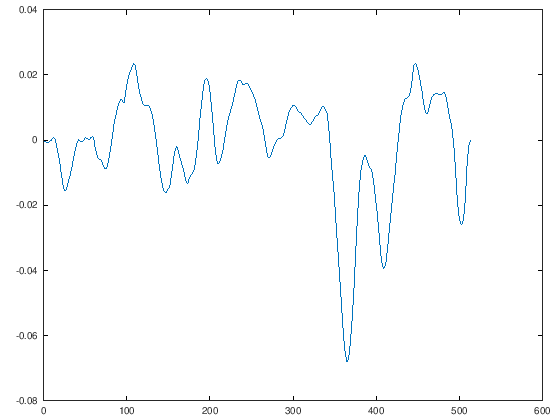

In [52]:
CI=b'*Weights;
plot(CI)
plot(diff(CI))